In [21]:
%matplotlib inline
#import ipywidgets as widgets
#from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
#from scipy.spatial.distance import cdist
#from numpy.linalg import inv
import george
from george.kernels import ExpSine2Kernel, ExpSquaredKernel
import astropy
from astropy.io import fits
import lightkurve
#import celerite
#from celerite import terms

### 1) Inspect the data

Downloaded directly from https://archive.stsci.edu/k2/preview.php?dsn=ktwo246301900-c12&type=lc

Metadata

In [35]:
import pandas as pd

filename = '/Users/chrislam/Desktop/epic-246301900/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chrislam/Desktop/epic-246301900/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [36]:
data = fits.getdata(filename,header=True,ext=1)
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(df.head())

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR       SAP_BKG  \
0  2905.377230  0.005332     136855  614164.8125     22.716827  19529.195312   
1  2905.397662  0.005331     136856  614196.0000     22.708811  19530.005859   
2  2905.418095  0.005329     136857  614179.6250     22.713530  19541.736328   
3  2905.438527  0.005328     136858  614099.5000     22.717106  19533.994141   
4  2905.458959  0.005327     136859  614238.1875     22.723835  19532.445312   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  PSF_CENTR1  \
0     7.201994          NaN              NaN       524288         NaN   
1     7.175916  612915.2500        22.353420            0         NaN   
2     7.180060  612892.8125        22.366695            0         NaN   
3     7.191803  612824.8125        22.378389            0         NaN   
4     7.191343  612975.3750        22.391329            0         NaN   

   PSF_CENTR1_ERR  PSF_CENTR2  PSF_CENTR2_ERR  MOM_CENTR1  MOM_CENTR1_ERR  \
0  

Download light curve from MAST

In [16]:
flc = lightkurve.search_lightcurve("EPIC 246301900", cadence="long", campaign=12, mission="K2")
print(flc)

SearchResult containing 3 data products.

 #     mission     year  author exptime  target_name  distance
                                   s                   arcsec 
--- -------------- ---- ------- ------- ------------- --------
  0 K2 Campaign 12 2016      K2    1800 ktwo246301900      0.0
  1 K2 Campaign 12 2016 EVEREST    1800 ktwo246301900      0.0
  2 K2 Campaign 12 2016   K2SFF    1800 ktwo246301900      0.0


In [18]:
download = flc[2].download()

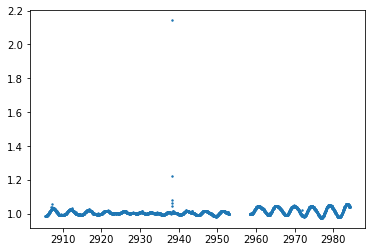

In [43]:
plt.scatter(download.time.value, download.flux.value, s=2)
plt.show()

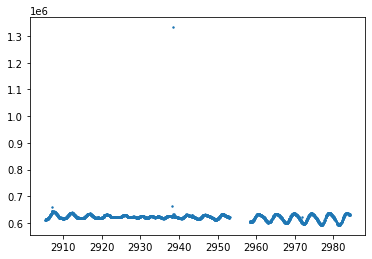

In [44]:
plt.scatter(df.TIME, df.PDCSAP_FLUX, s=2)
plt.show()

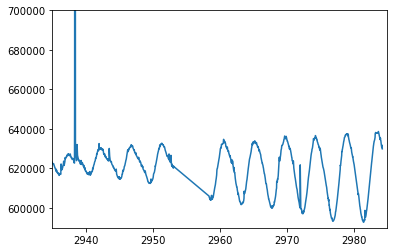

In [45]:
# examine the gap
plt.plot(df.TIME, df.PDCSAP_FLUX)
plt.xlim([2935,2985])
plt.ylim([590000,700000])
plt.show()

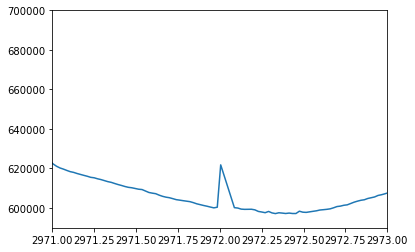

3256    601289.4375
3257    600915.5625
3258    600486.1250
3259    600089.1250
3260    600415.0000
3261    621832.1875
3265    600196.0000
Name: PDCSAP_FLUX, dtype: float32


In [46]:
# examine spike/possible flare shortly after 2970 BJD
plt.plot(df.TIME, df.PDCSAP_FLUX)
plt.xlim([2971,2973])
plt.ylim([590000,700000])
plt.show()

print(df.loc[(df.TIME>2971.9) & (df.TIME<2972.1)].PDCSAP_FLUX)

### 2) GP Modeling

3255


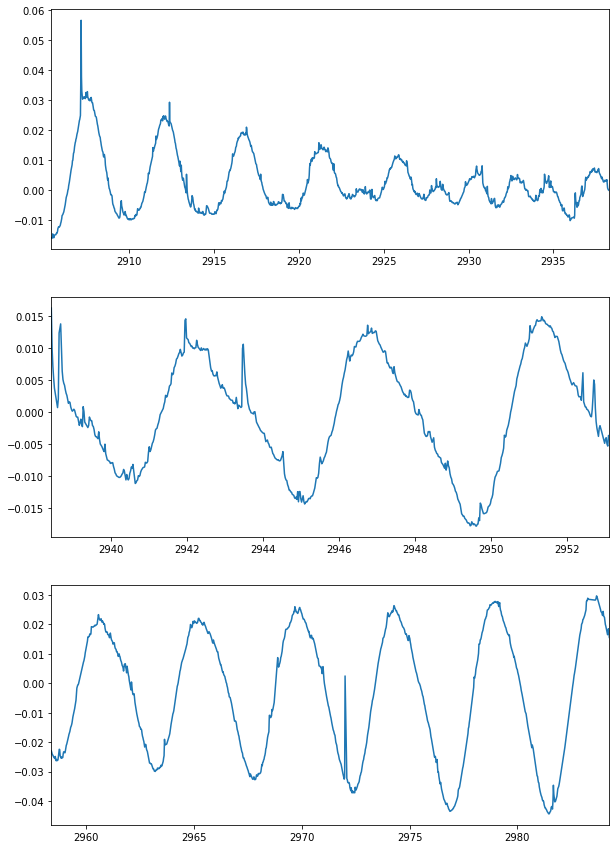

In [118]:
# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder())
df = df.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(df))

pre = df.loc[:1611] # next record is the beginning of the flare, so stop here
post = df.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = df.loc[2337:] # start from end of the gap in data until end of time series data

plt.figure(figsize=(10,15))
plt.subplot(311)
xobs = np.array(pre["TIME"])
yobs = np.array(pre["PDCSAP_FLUX"])
plt.xlim(min(pre.TIME),max(pre.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(312)
xobs = np.array(post["TIME"])
yobs = np.array(post["PDCSAP_FLUX"])
plt.xlim(min(post.TIME),max(post.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)

plt.subplot(313)
xobs = np.array(postgap["TIME"])
yobs = np.array(postgap["PDCSAP_FLUX"])
plt.xlim(min(postgap.TIME),max(postgap.TIME))
#plt.ylim(590000,660000)
plt.plot(xobs,yobs/np.median(yobs)-1)
plt.show()

Pre-super-flare

[612915.25 612892.8  612824.8  ... 622910.75 622810.2  622744.44]
[22.35342  22.366695 22.37839  ... 22.937845 22.940638 22.949953]
[3.6470654e-05 3.6493650e-05 3.6516780e-05 ... 3.6823647e-05 3.6834077e-05
 3.6852922e-05]


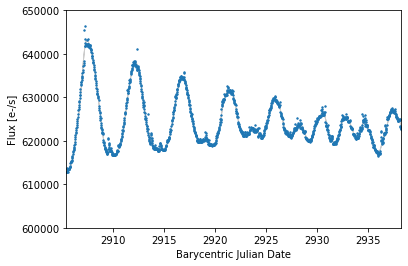

[612915.25 612892.8  612824.8  ... 622910.75 622810.2  622744.44]
[612618.92896777 612804.18461946 612963.9255443  ... 623070.7172213
 622716.37750874 622305.10046592]


In [54]:
lhs_pre = min(pre.TIME)
rhs_pre = max(pre.TIME)
xobs_pre = np.array(pre["TIME"])
yobs_pre = np.array(pre["PDCSAP_FLUX"])
eobs_pre = np.array(pre["PDCSAP_FLUX_ERR"])
print(yobs)
print(eobs)
print(np.abs(eobs/yobs))

kernel_pre = np.var(yobs_pre) * ExpSquaredKernel(0.5)
gp_pre = george.GP(kernel_pre)
gp_pre.compute(xobs_pre, eobs_pre)

pred_pre, pred_var_pre = gp.predict(yobs_pre, xobs_pre, return_var=True)

plt.fill_between(xobs_pre, pred_pre - np.sqrt(pred_var_pre), pred_pre + np.sqrt(pred_var_pre),
                color="k", alpha=0.2)
#plt.plot(xobs, pred, "k", lw=1.5, alpha=0.5)
#plt.errorbar(xobs, yobs, yerr=eobs, fmt=".k", capsize=0)
plt.xlim(lhs, rhs)
#plt.xlim(lhs,2910)
plt.ylim(600000,650000)
plt.xlabel(r'Barycentric Julian Date')
plt.ylabel(r'Flux [e-/s]')
plt.scatter(xobs_pre, yobs_pre, s=2)
plt.show()

print(yobs_pre)
print(pred_pre)

Same for post and postgap

In [96]:
def alias(df, normalized_flag):
    """
    Params:
    - df: Pandas DataFrame representing light curve from MAST
    - normalized_flag: to normalize or not to normalize (Boolean)
    
    Returns:
    - George-GP-smoothed predicted light curve (list of floats)
    """
    
    lhs = min(df.TIME)
    rhs = max(df.TIME)
    xobs = np.array(df["TIME"])
    yobs = np.array(df["PDCSAP_FLUX"])
    eobs = np.array(df["PDCSAP_FLUX_ERR"])
    
    kernel = np.var(yobs) * ExpSquaredKernel(0.5)
    gp = george.GP(kernel)
    gp.compute(xobs, eobs)

    if normalized_flag==False:
        pred, pred_var = gp.predict(yobs, xobs, return_var=True)
        
        return pred, pred_var
    
    elif normalized_flag==True:
        yobs_norm = yobs/np.median(yobs) - 1
        pred, pred_var = gp.predict(yobs_norm, xobs, return_var=True)
        
        return pred, pred_var

pred_pre, pred_var_pre = alias(pre, normalized_flag=True)
pred_post, pred_var_post = alias(post, normalized_flag=True)
pred_postgap, pred_var_postgap = alias(postgap, normalized_flag=True)


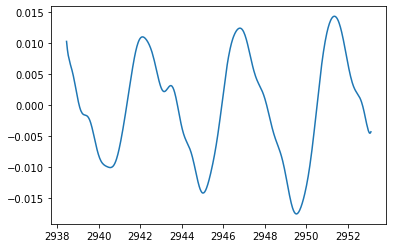

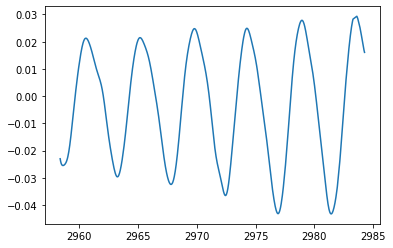

In [92]:
plt.plot(post.TIME, pred_post)
plt.show()

plt.plot(postgap.TIME, pred_postgap)
plt.show()

### 3) Inject flares

Pieces taken from Ekaterina Ilin's Altaipony: https://github.com/ekaterinailin/AltaiPony/blob/037bd76c8ed09ed6340cf2105d1e83bc302168eb/altaipony/flarelc.py

In [114]:
from altaipony.fakeflares import generate_fake_flare_distribution, mod_random, aflare

def inject_fakes(error, flux, df, num_flares):
    
    def _equivalent_duration(time, flux):
            '''
            Compute the Equivalent Duration of a fake flare.
            This is the area under the flare, in relative flux units.
            Parameters:
            -------------
            time : numpy array
                units of DAYS
            flux : numpy array
                relative flux units
            Return:
            ------------
            p : float
                equivalent duration of a single event in units of seconds
            '''
            x = time * 60.0 * 60.0 * 24.0
            integral = np.sum(np.diff(x) * flux[:-1])
            return integral
        
    # Init arrays for the synthetic flare parameters
    nfake = num_flares # 20 flares per time chunk for a total of 60 fake flares
    t0_fake = np.zeros(nfake, dtype='float') # peak times
    ed_fake = np.zeros(nfake, dtype='float') # ED
    #dur_fake = np.zeros(nfake, dtype='float') # duration
    #ampl_fake = np.zeros(nfake, dtype='float') # amplitude

    # Init the synthetic flare counter to allow to point to the right
    # places in the arrays above (XXX_fake etc.)
    ckm = 0

    # Pick flux, time, and flux error arrays 
    error = error # pred_var_pre
    flux = flux # pred_pre
    time = np.array(df.TIME)
    #print(np.array(time))
    #print(download.time.value)
    
    # generate the time constraints for the flares you want to inject
    mintime, maxtime = np.min(time), np.max(time)
    dtime = maxtime - mintime

    # generate a distribution of durations and amplitudes
    d = False
    seed = 23 # mashed keyboard idk
    #default: ampl=[1e-4, 5], dur=[0.005, 0.012]
    distribution  = generate_fake_flare_distribution(nfake, d=d,
                                            seed=seed)
    dur_fake = distribution[0]
    ampl_fake = distribution[1]    
    
    for k in range(nfake):
        # add the peak time to the list and note the index
        t0 = (mod_random(1, d=d) * dtime + mintime)[0]
        t0_fake[k] = t0
    
        # generate the flare flux from the Davenport 2014 model
        fl_flux = aflare(time, t0, dur_fake[k], ampl_fake[k])

        # calculate the injected ED
        ed_fake[k] = _equivalent_duration(time, fl_flux)
        
        # inject flare into light curve by adding the flare flux
        flux = flux + fl_flux
        #fake_lc[typ].value[le:ri] = (fake_lc[typ][le:ri].value +
        #                            fl_flux * fake_lc.it_med[le:ri].value)
    
    return dur_fake, ampl_fake, t0_fake, ed_fake, flux

dur_fake_pre, ampl_fake_pre, t0_fake_pre, ed_fake_pre, flux_pre = inject_fakes(np.sqrt(pred_var_pre), 
                                                                    pred_pre, pre, num_flares=20)
dur_fake_post, ampl_fake_post, t0_fake_post, ed_fake_post, flux_post = inject_fakes(np.sqrt(pred_var_post), 
                                                                    pred_post, post, num_flares=10)
dur_fake_postgap, ampl_fake_postgap, t0_fake_postgap, ed_fake_postgap, flux_postgap = inject_fakes(np.sqrt(pred_var_postgap), 
                                                                    pred_postgap, postgap, num_flares=20)

In [115]:
print(dur_fake_pre)
print(ampl_fake_pre)
print(t0_fake_pre)
print(ed_fake_pre)
print(flux)

[0.00661545 0.00918567 0.01179522 0.0057406  0.00882266 0.00915142
 0.00548455 0.00693151 0.00922834 0.00637648 0.00633637 0.01197534
 0.01119035 0.00860458 0.00713534 0.00990039 0.0059207  0.00817336
 0.00540001 0.00833813]
[4.26266991 3.9244162  3.14259247 3.61146402 2.37926771 2.0855557
 4.38360768 0.99237032 2.89958667 0.99635937 0.49829005 3.67644077
 4.41376141 3.52350662 2.18218948 4.33574663 2.98145184 3.11251065
 4.91065225 4.63037196]
[2932.49792327 2925.24815407 2914.70659127 2921.59708635 2911.4084679
 2909.87462536 2922.18738462 2910.4632355  2909.24738755 2934.10583549
 2933.78861804 2936.40890413 2908.57273644 2916.15987847 2911.57131076
 2923.21086971 2917.21807869 2928.73565194 2925.33206178 2932.24656282]
[  29.99532549 1844.50342808 2271.6496404  2371.08092125  688.52771863
 1234.55358792 1914.24949446  112.10373057 1119.13631428  658.59406077
  144.37871969 3988.50308761 2157.90682355 2346.343553    431.54634242
  883.85250223  762.49893514  765.48873266 1493.606405

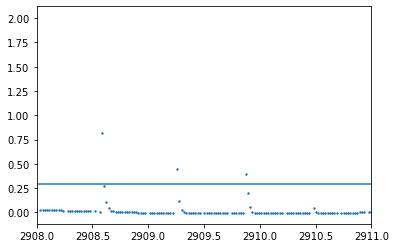

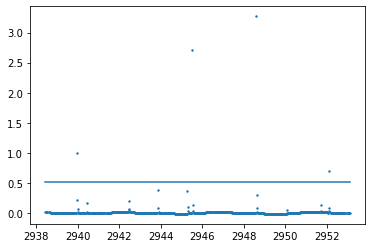

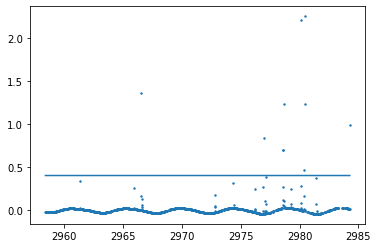

In [148]:
### did I do it?
plt.scatter(pre.TIME, flux_pre, s=2)
plt.plot(pre.TIME, np.ones(len(pre))*np.median(flux_pre)+3*np.std(flux_pre))
plt.xlim(2908, 2911)
plt.show()

plt.scatter(post.TIME, flux_post, s=2)
plt.plot(post.TIME, np.ones(len(post))*np.median(flux_post)+3*np.std(flux_post))
plt.show()

plt.scatter(postgap.TIME, flux_postgap, s=2)
plt.plot(postgap.TIME, np.ones(len(postgap))*np.median(flux_postgap)+3*np.std(flux_postgap))
plt.show()
### yes I did!

### 4) Recover fake flares

In [137]:
print(np.abs(flux_pre))
print(np.abs(flux_pre) / np.sqrt(pred_var_pre))
print(np.abs(flux_pre) / pred_var_pre)
print(np.median(flux_pre))
print(np.median(flux_pre)+3*np.std(flux_pre))


[1.60955132e-02 1.59712913e-02 1.58403865e-02 ... 3.84011199e-04
 5.80744097e-05 5.43548926e-04]
[1.11307572e-03 1.43298206e-03 1.76217826e-03 ... 4.12645707e-05
 5.05809648e-06 3.66782126e-05]
[7.69740953e-05 1.28570543e-04 1.96035129e-04 ... 4.43415400e-06
 4.40544126e-07 2.47501415e-06]
0.0006496890403830946
0.29407635719524544


In [155]:
flux = flux_pre
var = pred_var_pre
T0 = flux # excursion should be positive #"N0"
T1 = np.abs(flux) / np.std(flux) #N1
T2 = np.abs(flux - np.sqrt(var)) / np.std(flux) #N2
minsep = 3
N1 = 3
N2 = 3
N3 = 2
istart = np.array([], dtype='int')
istop = np.array([], dtype='int')

pass_thresholds = np.where((T0 > 0) & (T1 > N1) & (T2 > N2))
print("pass thresholds: ", pass_thresholds)

#array of indices where thresholds are exceeded:
is_pass_thresholds = np.zeros_like(flux)
is_pass_thresholds[pass_thresholds] = 1

# test based on consecutive points
reverse_counts = np.zeros_like(flux, dtype='int')
for k in range(2, len(flux)):
    reverse_counts[-k] = (is_pass_thresholds[-k]
                            * (reverse_counts[-(k-1)]
                            + is_pass_thresholds[-k]))

# find flare start where values in reverse_counts switch from 0 to >=N3
istart_i = np.where((reverse_counts[1:] >= N3) &
                    (reverse_counts[:-1] - reverse_counts[1:] < 0))[0] + 1

# use the value of reverse_counts to determine how many points away stop is
istop_i = istart_i + (reverse_counts[istart_i])

# Create boolean flare mask
isflare = np.zeros_like(flux, dtype='bool')

for (l,r) in list(zip(istart_i, istop_i)):
    isflare[l:r+1] = True
    
print(isflare)

### 

# now pick out final flare candidate indices
candidates = np.where( isflare > 0)[0]
print("candidates: ", candidates)
if (len(candidates) < 1):#no candidates = no indices
    istart_gap = np.array([])
    istop_gap = np.array([])
else:
    # find start and stop index, combine neighboring candidates
    # in to same events
    separated_candidates = np.where( (np.diff(candidates)) > minsep )[0]
    istart_gap = candidates[ np.append([0], separated_candidates + 1) ]
    istop_gap = candidates[ np.append(separated_candidates,
                            [len(candidates) - 1]) ]

print(istart_gap)
print(istop_gap)
#stitch indices back into the original light curve
#istart = np.array(np.append(istart, istart_gap + le), dtype='int')
#istop = np.array(np.append(istop, istop_gap + le), dtype='int')



pass thresholds:  (array([ 142,  173,  201,  426,  492,  543,  751,  778,  824,  917,  921,
       1078, 1236, 1237, 1318, 1424, 1425]),)
[False False False ... False False False]
candidates:  [1236 1237 1238 1424 1425 1426]
[1236 1424]
[1238 1426]
